# SVM

Train SVM classifier to distinguish between normal and pathologic gaits from wireless sensor data. 

Code adapted from scikit-learn [Parameter estimation using grid search with cross-validation](http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py).

In [1]:
import itertools

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np

In [4]:
import os.path

In [5]:
import pandas as pd

In [6]:
import pickle

In [7]:
import psutil

In [8]:
import time

In [9]:
from pympler import asizeof

In [10]:
from sklearn import svm

In [11]:
from sklearn.metrics import confusion_matrix

In [12]:
from sklearn.metrics import auc, roc_curve

In [13]:
from sklearn.model_selection import GridSearchCV

In [14]:
from sklearn.model_selection import train_test_split

---

**2018 May 4, 7-9; July 27-29; August 20**

Read in data:

In [15]:
datafile = os.path.join('..', 'data', 'processed', 'combined_cond_ranges.csv')
data = pd.read_csv(datafile)

In [16]:
X = data.iloc[:, 1:7].values
y = data.iloc[:, 7].values

In [13]:
X.shape

(319, 6)

In [17]:
class_names = ['Normal', 'Abnormal']

Split data into 80% training and 20% test:

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
print(f'Training set size: {X_train.shape[0]} ({np.sum(y_train)} positives)', 
      f'Test set size: {X_test.shape[0]} ({np.sum(y_test)} positives)', sep='\n')

Training set size: 255 (47 positives)
Test set size: 64 (12 positives)


Set candidate parameters to be evaluated by cross-validation:

In [20]:
tuning_params = [{'kernel': ['rbf'], 'gamma': [0.1, 1e-2, 1e-3], 'C': [1000, 1e+04]}, 
                 {'kernel': ['linear'], 'C': [10, 100, 1000, 1e+04, 1e+05]}]

Conduct grid search with *n*-fold CV to find parameters producing highest score:

In [21]:
n_folds = 3
clf = GridSearchCV(svm.SVC(class_weight='balanced'), tuning_params, 
                   scoring='roc_auc', cv=n_folds)
clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'kernel': ['rbf'], 'gamma': [0.1, 0.01, 0.001], 'C': [1000, 10000.0]}, {'kernel': ['linear'], 'C': [10, 100, 1000, 10000.0, 100000.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [22]:
##f'The mean CV accuracy score of the best estimator is {clf.best_score_:0.4}'
f'The CV score of the best estimator is {clf.best_score_:0.4}'

'The CV score of the best estimator is 0.9681'

In [23]:
print(f'Best parameters set found from {n_folds}-fold CV:', 
      clf.best_params_, sep='\n')

Best parameters set found from 3-fold CV:
{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}


In [24]:
means = clf.cv_results_['mean_test_score']
for mean, params in zip(means, clf.cv_results_['params']):
    print("%0.3f for %r" % (mean, params))

0.968 for {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}
0.944 for {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
0.922 for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.964 for {'C': 10000.0, 'gamma': 0.1, 'kernel': 'rbf'}
0.942 for {'C': 10000.0, 'gamma': 0.01, 'kernel': 'rbf'}
0.945 for {'C': 10000.0, 'gamma': 0.001, 'kernel': 'rbf'}
0.936 for {'C': 10, 'kernel': 'linear'}
0.944 for {'C': 100, 'kernel': 'linear'}
0.941 for {'C': 1000, 'kernel': 'linear'}
0.941 for {'C': 10000.0, 'kernel': 'linear'}
0.938 for {'C': 100000.0, 'kernel': 'linear'}


Save trained model

In [25]:
with open(os.path.join('..', 'results', 'svm_trained.pkl'), 'wb') as f:
    pickle.dump(clf, f)

Load trained classifier

In [19]:
with open(os.path.join('..', 'results', 'svm_trained.pkl'), 'rb') as f:
    clf = pickle.load(f)

Predict on test set and report execution time

In [26]:
%timeit clf.predict(X_test)

129 µs ± 1.18 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [20]:
y_pred = clf.predict(X_test)

In [22]:
f'Accuracy on test set: {clf.score(X_test, y_test):0.4}'
##f'AUC on test set: {clf.score(X_test, y_test):0.4}'

'Accuracy on test set: 0.9688'

Find memory usage of `SVC` classifier object

In [29]:
asizeof.asizeof(clf)

21656

Construct confusion matrix (code copied from scikit-learn [Confusion matrix](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py)):

In [34]:
def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    Print and plot confusion matrix. Normalization can be applied by setting 
    `normalize=True`
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize='xx-large')
    tick_marks = np.arange(len(classes))
    ax = plt.gca()
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, fontsize='large')
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes, rotation=90, va='center', minor=False, 
                       fontsize='large')
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i,j], fmt), horizontalalignment='center', 
                 fontsize=20, color='white' if cm[i,j] > thresh else 'black')
    plt.tight_layout()
    plt.xlabel('Predicted label', fontsize='x-large')
    plt.ylabel('True label', fontsize='x-large')

In [35]:
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

Confusion matrix
[[50  2]
 [ 0 12]]


<Figure size 640x480 with 0 Axes>

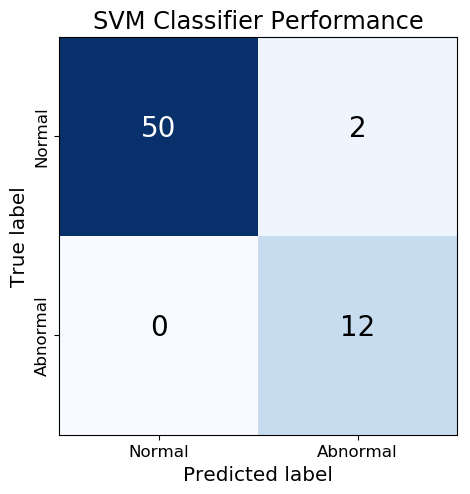

In [37]:
plot_title = 'SVM Classifier Performance'
plt.clf()
plt.style.use('default')
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title=plot_title)
cnf_filename = os.path.join('..', 'results', 'svm_cnf_matrix.svg')
plt.savefig(cnf_filename)
plt.show()

In [38]:
spec, sens = cnf_matrix.diagonal() / np.sum(cnf_matrix, axis=1)
print(f'Sensitivity = {sens}\nSpecificity = {spec}')

Sensitivity = 1.0
Specificity = 0.9615384615384616


Plot ROC curve. The classifier score will be the distance of samples to the separating hyperplane.

In [39]:
y_score = clf.decision_function(X_test)

In [40]:
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

<Figure size 640x480 with 0 Axes>

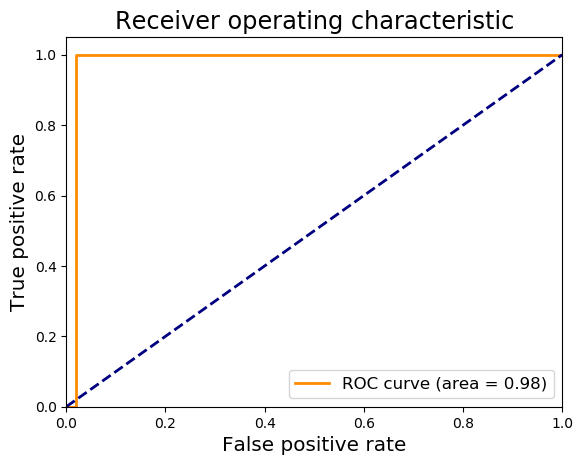

In [43]:
plt.clf()
plt.style.use('default')
plt.figure()
lw_ = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw_, 
         label='ROC curve (area = %0.2f)' %roc_auc)
plt.plot([0,1], [0,1], color='navy', lw=lw_, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate', fontsize='x-large')
plt.ylabel('True positive rate', fontsize='x-large')
plt.title('Receiver operating characteristic', fontsize='xx-large')
plt.legend(loc='lower right', fontsize='large')
roc_filename = os.path.join('..', 'results', 'svm_roc.svg')
plt.savefig(roc_filename)
plt.show()